In [1]:
import pandas as pd
import torch
from torch.utils.data import DataLoader
from sentence_transformers import InputExample, SentenceTransformer, losses
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from sklearn.metrics import mean_squared_error
import numpy as np
from scipy.stats import pearsonr

/home/medhahira/miniconda3/envs/A3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load datasets
train_df = pd.read_csv('A3_task1_data_files/train.csv', sep='\t')
dev_df = pd.read_csv('A3_task1_data_files/dev.csv', sep='\t')

# Correct column name typo in dev dataset
dev_df.rename(columns={'setence1': 'sentence1'}, inplace=True)

In [3]:
# Convert DataFrames into lists of InputExample
train_examples = [InputExample(texts=[str(row['sentence1']), str(row['sentence2'])], label=float(row['score'])/5.0) for _, row in train_df.iterrows()]
dev_examples = [InputExample(texts=[str(row['sentence1']), str(row['sentence2'])], label=float(row['score'])/5.0) for _, row in dev_df.iterrows()]

# Initialize the model
model_path = "all-MiniLM-L6-v2"
model = SentenceTransformer(model_path)

In [4]:
# Define function to calculate cosine similarity loss (MSE)
def calculate_cosine_similarity_loss(model, examples):
    embeddings1 = model.encode([example.texts[0] for example in examples], convert_to_tensor=True, show_progress_bar=False)
    embeddings2 = model.encode([example.texts[1] for example in examples], convert_to_tensor=True, show_progress_bar=False)
    
    # Calculate cosine similarities
    cosine_similarities = torch.cosine_similarity(embeddings1, embeddings2)
    true_labels = torch.tensor([example.label for example in examples])
    
    # Calculate MSE loss
    mse_loss = mean_squared_error(true_labels.cpu().numpy(), cosine_similarities.cpu().numpy())
    return mse_loss

# Prepare to store losses
train_losses = []
val_losses = []

# Train the model one epoch at a time and manually compute loss
num_epochs = 5

for epoch in range(num_epochs):
    # Fine-tune the model for one epoch
    model.fit(train_objectives=[(DataLoader(train_examples, shuffle=True, batch_size=16), losses.CosineSimilarityLoss(model))],
              epochs=1,
              warmup_steps=100,
              output_path=f'fine-tuned-model_epoch_{epoch}')  # Save the model after each epoch with a unique name
    
    # Load the model from the saved directory
    model = SentenceTransformer(f'fine-tuned-model_epoch_{epoch}')
    
    # Manually evaluate by running inference and compute loss on both datasets
    train_loss_value = calculate_cosine_similarity_loss(model, train_examples)
    val_loss_value = calculate_cosine_similarity_loss(model, dev_examples)
    
    # Store the calculated losses
    train_losses.append(train_loss_value)
    val_losses.append(val_loss_value)
    
    print(f"Epoch {epoch + 1}: Train Loss: {train_loss_value}, Validation Loss: {val_loss_value}")


Epoch: 100%|██████████| 1/1 [00:07<00:00,  7.64s/it]


Epoch 1: Train Loss: 0.02024085447192192, Validation Loss: 0.021983260288834572


Epoch: 100%|██████████| 1/1 [00:06<00:00,  6.88s/it]


Epoch 2: Train Loss: 0.01571591943502426, Validation Loss: 0.021682484075427055


Epoch: 100%|██████████| 1/1 [00:06<00:00,  6.68s/it]


Epoch 3: Train Loss: 0.012271462008357048, Validation Loss: 0.021069008857011795


Epoch: 100%|██████████| 1/1 [00:07<00:00,  7.04s/it]


Epoch 4: Train Loss: 0.010013352148234844, Validation Loss: 0.02110494300723076


Epoch: 100%|██████████| 1/1 [00:06<00:00,  6.89s/it]


Epoch 5: Train Loss: 0.008293652907013893, Validation Loss: 0.021663952618837357


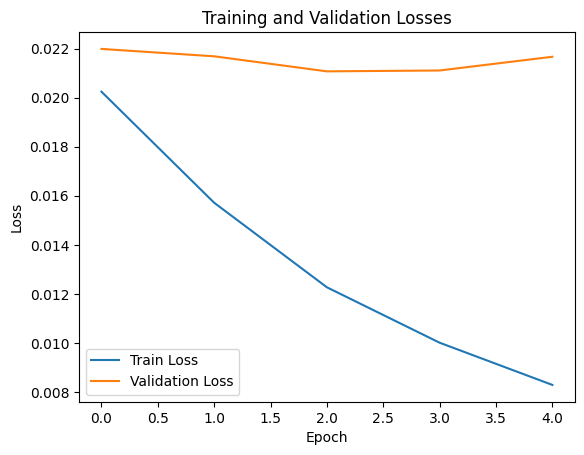

In [5]:
# Plot the training and validation losses
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')

plt.legend()
plt.show()

In [6]:
# Load the final model
model = SentenceTransformer(f'fine-tuned-model_epoch_4')

# Function to compute predictions
def compute_predictions(model, examples):
    embeddings1 = model.encode([example.texts[0] for example in examples], convert_to_tensor=True, show_progress_bar=False)
    embeddings2 = model.encode([example.texts[1] for example in examples], convert_to_tensor=True, show_progress_bar=False)
    
    # Calculate cosine similarities
    cosine_similarities = torch.cosine_similarity(embeddings1, embeddings2).cpu().numpy()
    return cosine_similarities

# Compute predictions for the dev dataset
predicted_similarities = compute_predictions(model, dev_examples)

# Extract the true labels/scores
true_labels = np.array([example.label for example in dev_examples])

# Calculate the Pearson correlation coefficient
pearson_corr, _ = pearsonr(predicted_similarities, true_labels)

print(f"Pearson Correlation Coefficient: {pearson_corr}")

Pearson Correlation Coefficient: 0.8897935034684425
